In [8]:
!pip install tensorflow scikit-learn pandas openpyxl matplotlib


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Input, Dropout,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam


In [10]:
df_train = pd.read_excel('Patient_Training_Dataset.xlsx')
df_test = pd.read_csv('data_device_4_variables_3O2Y83P1SO.csv')

# Auto-label test data
def classify(row):
    if (row['temperature'] < 35.2 or row['temperature'] > 40.1 or
        row['heart_rate'] < 60 or row['heart_rate'] > 100 or
        row['spo2'] < 93):
        return 1
    return 0

df_test['label'] = df_test.apply(classify, axis=1)


In [14]:
# Step 3: Updated to match train size
sequence_length = 20  # was 10
features = ['temperature', 'heart_rate', 'spo2']
X_test, y_test = [], []

for i in range(len(df_test) - sequence_length + 1):
    temp_seq = df_test.iloc[i:i+sequence_length][features].values
    ecg_seq = df_test.iloc[i:i+sequence_length]['ecg'].values
    label = df_test.iloc[i+sequence_length-1]['label']
    sequence = np.hstack((temp_seq, ecg_seq.reshape(-1, 1)))
    X_test.append(sequence)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)


In [15]:
X_train_seq, y_train = [], []

for _, row in df_train.iterrows():
    temp = row['temperature']
    hr = row['heartRate']
    spo2 = row['spo2']
    ecg_values = row[[f'ecg_{i}' for i in range(200)]].values.reshape(-1, 20)

    for ecg_chunk in ecg_values:
        chunk = np.column_stack((
            np.full((20, 1), temp),
            np.full((20, 1), hr),
            np.full((20, 1), spo2),
            ecg_chunk.reshape(-1, 1)
        ))
        X_train_seq.append(chunk)
        y_train.append(row['label'])

X_train = np.array(X_train_seq)
y_train = np.array(y_train)

# Normalize and split
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, test_size=0.8, stratify=y_train, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small.reshape(-1, 4)).reshape(X_train_small.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 4)).reshape(X_test.shape)


In [16]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(MaxPooling1D(2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train_scaled, y_train_small, epochs=10, batch_size=16, validation_split=0.2)
cnn_accuracy = cnn_model.evaluate(X_test_scaled, y_test, verbose=0)[1]


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4964 - loss: 0.7084 - val_accuracy: 0.5200 - val_loss: 0.6943
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5393 - loss: 0.6818 - val_accuracy: 0.5150 - val_loss: 0.7043
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6187 - loss: 0.6521 - val_accuracy: 0.5500 - val_loss: 0.7127
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6228 - loss: 0.6455 - val_accuracy: 0.5600 - val_loss: 0.6884
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6520 - loss: 0.6232 - val_accuracy: 0.5450 - val_loss: 0.7101
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6464 - loss: 0.6285 - val_accuracy: 0.5550 - val_loss: 0.7149
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6708 - loss: 0.6052 - val_accuracy: 0.5350 - val_loss: 0.7024
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6664 - loss: 0.6071 - val_accuracy: 0.5550 - val_loss:

In [18]:
#  Step 6: Transformer Model with Input Projection

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(embed_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.norm2(out1 + ffn_output)

#  Project input to match embed_dim
embed_dim = 64
inputs = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))  # (20, 4)
x = Dense(embed_dim)(inputs)  # Project input to (20, 64)
x = TransformerBlock(embed_dim=embed_dim, num_heads=2)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation='sigmoid')(x)

transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_transformer = transformer_model.fit(X_train_scaled, y_train_small, epochs=10, batch_size=16, validation_split=0.2)
transformer_accuracy = transformer_model.evaluate(X_test_scaled, y_test, verbose=0)[1]


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4791 - loss: 0.8147 - val_accuracy: 0.5900 - val_loss: 0.7105
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5371 - loss: 0.7310 - val_accuracy: 0.5400 - val_loss: 0.6830
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5473 - loss: 0.6779 - val_accuracy: 0.4950 - val_loss: 0.7174
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5531 - loss: 0.6920 - val_accuracy: 0.5300 - val_loss: 0.6959
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5570 - loss: 0.6829 - val_accuracy: 0.5750 - val_loss: 0.6609
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6345 - loss: 0.6553 - val_accuracy: 0.5750 - val_loss: 0.6784
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5819 - loss: 0.6687 - val_accuracy: 0.5550 - val_loss: 0.6857
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5432 - loss: 0.6847 - val_accuracy: 0.5100 - val_loss

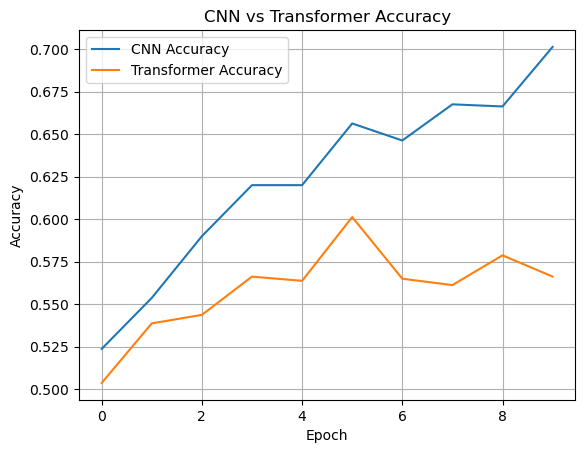

CNN Accuracy: 37.50%
Transformer Accuracy: 12.50%


In [19]:
# 📊 Plot accuracy comparison
plt.plot(history_cnn.history['accuracy'], label='CNN Accuracy')
plt.plot(history_transformer.history['accuracy'], label='Transformer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN vs Transformer Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 🧾 Final Accuracy Output
print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")
print(f"Transformer Accuracy: {transformer_accuracy * 100:.2f}%")


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions (rounded)
y_pred_cnn = (cnn_model.predict(X_test_scaled) > 0.5).astype(int)
y_pred_transformer = (transformer_model.predict(X_test_scaled) > 0.5).astype(int)

print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn))
print("Transformer Classification Report:\n", classification_report(y_test, y_pred_transformer))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.50      0.17         4
           1       0.83      0.36      0.50        28

    accuracy                           0.38        32
   macro avg       0.47      0.43      0.33        32
weighted avg       0.74      0.38      0.46        32

Transformer Classification Report:
               precision    recall  f1-score   support

           0       0.12      1.00      0.22         4
           1       0.00      0.00      0.00        28

    accuracy                           0.12        32
   macro avg       0.06      0.50      0.11        32
weighted avg       0.02      0.12      0.03        32



C:\Users\Laptop Land\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Laptop Land\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Laptop Land\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
import pandas as pd

# Get predictions from trained model
y_pred = (cnn_model.predict(X_test_scaled) > 0.5).astype(int)

# Reconstruct a DataFrame with original test data (latest 32 rows only)
output_df = df_test.iloc[-len(y_pred):].copy()  # make sure it's same length as X_test
output_df = output_df[['temperature', 'heart_rate', 'spo2', 'ecg', 'label']]

# Add AI prediction column
output_df['predicted_label'] = y_pred

# Map 0/1 to readable class
output_df['status'] = output_df['predicted_label'].map({0: 'Normal', 1: 'Abnormal'})

# Show result
from IPython.display import display
display(output_df.tail(20))  # show last 20 entries


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


,temperature,heart_rate,spo2,ecg,label,predicted_label,status
31,35.7500,186.828094,95.0,807.0,1,0,Normal
32,35.1250,0.000000,0.0,1024.0,1,0,Normal
33,35.3125,0.000000,0.0,8.0,1,0,Normal
34,35.2500,183.358948,95.0,135.0,1,1,Abnormal
35,35.2500,0.000000,0.0,1024.0,1,1,Abnormal
36,35.4375,62.892078,94.0,188.0,0,1,Abnormal
37,35.3750,0.000000,0.0,1024.0,1,0,Normal
38,35.6250,0.000000,0.0,969.0,1,0,Normal
39,35.5625,0.000000,0.0,1024.0,1,0,Normal
40,35.6250,127.032234,95.0,893.0,1,1,Abnormal


In [22]:
output_df.to_csv('Predicted_Results_CNN.csv', index=False)